<a href="https://colab.research.google.com/github/Jeong-ki-hun/Section2_Project/blob/main/%08AI_11_%EC%A0%95%EA%B8%B0%ED%9B%88(Section2_Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [217]:
!pip install category_encoders
!pip install shap
!pip install pandas_profiling
!pip install eli5
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 202 kB/s 
     |████████████████████████████████| 13.1 MB 41.8 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=7600a8edfc89e82d796b2da069659c4dd9fcf50e1a492d8937b46c0ac387b1e6
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling 

# 라이브러리 호출

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('font', family='NanumBarunGothic') 
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
import sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, OneHotEncoder
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import shap

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) 데이터 선정 이유 및 문제 정의

문제 정의 및 선정이유

중고차시장은 점점 커지며 대기업들까지도 진출하고있다.

하지만 소비자들은 중고차 시세에 대해 잘 알지못하는 편이다.

만약 중고차 시세 대해 알수 있다면 합리적인 가격으로 구매가능하며 보다 불편함없이 내가원하는 중고차를 구매할 수 있기 때문에 이데이터셋을 선택하였습니다.


## 데이터는 캐글의 영국 중고차데이터세트(경쟁형식)을 활용하였습니다.

컬럼설명


brand : 브랜드

model : 자동차 모델

year : 년식


transmission : 변속기


mileage : 주행거리


fuelType : 연료종류


tax : 세금


mpg : 연비


engineSize : 엔진사이즈


price:가격



출처 : https://www.kaggle.com/datasets/kukuroo3/used-car-price-dataset-competition-format

In [388]:
x_te = pd.read_csv('/content/drive/MyDrive/archive (14)/X_test.csv',encoding='cp949')
x_tr = pd.read_csv('/content/drive/MyDrive/archive (14)/X_train.csv',encoding='cp949')
y_tr = pd.read_csv('/content/drive/MyDrive/archive (14)/y_train.csv',encoding='cp949')
y_te = pd.read_csv('/content/drive/MyDrive/archive (14)/y_test.csv',encoding='cp949')
tr = pd.merge(x_tr,y_tr,how='inner',on='carID')
ts = pd.merge(x_te,y_te,how='inner',on='carID')
df = pd.concat([tr,ts]).reset_index(drop=True)

데이터를 평가지표, 베이스라인모델 선택

회귀문제이기 때문에 타켓의 평균값을 사용하여 처리

# 데이터 전처리 및 EDA

In [141]:
df.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2,31995
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0,7700
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9,58990
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0,12999
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0,16990


우선 필요없는 컬럼인 carid칼럼을 삭제시켜줍니다.

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7632 entries, 0 to 7631
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carID         7632 non-null   int64  
 1   brand         7632 non-null   object 
 2   model         7632 non-null   object 
 3   year          7632 non-null   int64  
 4   transmission  7632 non-null   object 
 5   mileage       7632 non-null   int64  
 6   fuelType      7632 non-null   object 
 7   tax           7632 non-null   float64
 8   mpg           7632 non-null   float64
 9   engineSize    7632 non-null   float64
 10  price         7632 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 656.0+ KB


In [143]:
df.isnull().sum()

carID           0
brand           0
model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
price           0
dtype: int64

In [389]:
df.drop(columns=['carID'],axis=1,inplace=True)

In [145]:
df['brand'].unique()

array(['hyundi', 'vauxhall', 'audi', 'vw', 'skoda', 'merc', 'toyota',
       'bmw', 'ford'], dtype=object)

In [146]:
df['model'].unique()

array([' Santa Fe', ' GTC', ' RS4', ' Scirocco', ' Scala', ' V Class',
       ' Prius', ' M4', ' Camry', ' KA', ' Vivaro', ' CLS Class',
       ' Caravelle', ' Arteon', ' Shuttle', ' I40', ' IX20', ' 6 Series',
       ' GL Class', ' S Class', ' S3', ' Yeti', ' Galaxy', ' Puma',
       ' Edge', ' A8', ' SLK', ' Kamiq', ' RS6', ' CLA Class',
       ' Land Cruiser', ' M Class', ' Q8', ' i3', ' Verso', ' Mustang',
       ' IX35', ' Amarok', ' Avensis', ' Grand Tourneo Connect',
       ' Antara', ' Tourneo Connect', ' Beetle', ' X4', ' CC', ' GT86',
       ' X-CLASS', ' I800', ' i8', ' Caddy Maxi Life', ' Combo Life',
       ' Rapid', ' SQ7', ' Grand C-MAX', ' Tourneo Custom', ' California',
       ' Agila', ' A7', ' Zafira Tourer', ' G Class', ' Tiguan Allspace',
       ' X6', ' M2', ' X7', ' 7 Series', ' Z4', ' RS5', ' Hilux',
       ' GLS Class', ' GLB Class', ' M5', ' RS3', ' Caddy Life', ' SQ5',
       ' Supra', ' 8 Series', ' Fusion', ' M6', ' M3', ' Jetta', ' S4',
       ' R8', ' PRO

In [338]:
model_count = df['model'].value_counts()

### 데이터 시각화

제조사별 평균단가

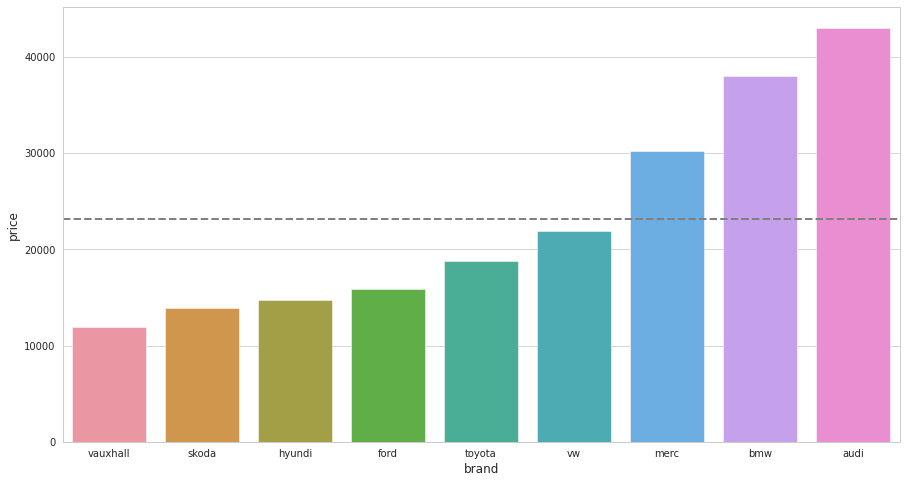

In [148]:
brand = df.groupby('brand')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=brand.index,y='price',data=brand)
plt.axhline(y = brand['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

연식별 평균단가

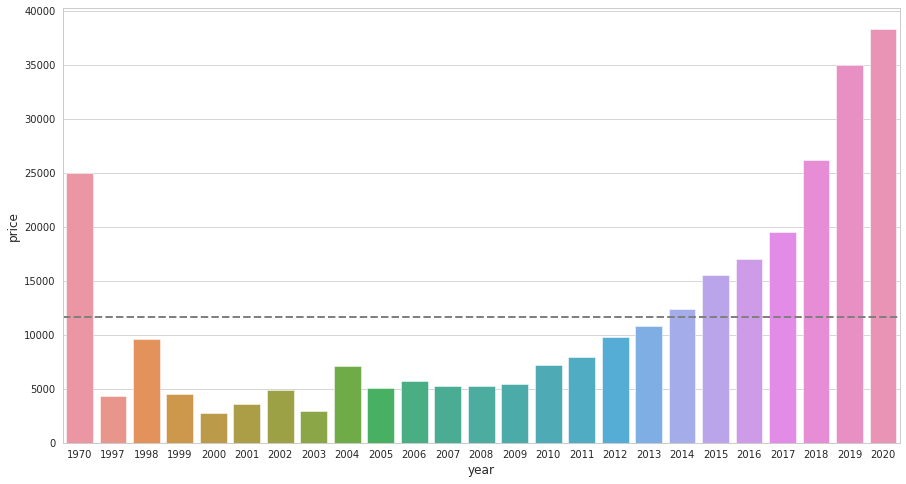

In [149]:
year = df.groupby('year')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=year.index,y='price',data=year)
plt.axhline(y = year['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

In [150]:
df.loc[df['year']==1970]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
6782,merc,M Class,1970,Automatic,14000,Diesel,305.0,39.2,0.0,24999


In [151]:
df.loc[df['year']==1998]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
3014,merc,S Class,1998,Automatic,43534,Petrol,265.0,23.3,6.0,19990
4578,merc,SLK,1998,Automatic,113557,Petrol,265.0,32.1,2.3,1990
6154,toyota,Land Cruiser,1998,Manual,100000,Diesel,265.0,23.9,4.2,19990
6984,merc,SLK,1998,Automatic,99300,Petrol,265.0,32.1,2.3,1990
7045,bmw,Z3,1998,Manual,56500,Petrol,270.0,35.3,1.9,3950


변속유형별 평균단가

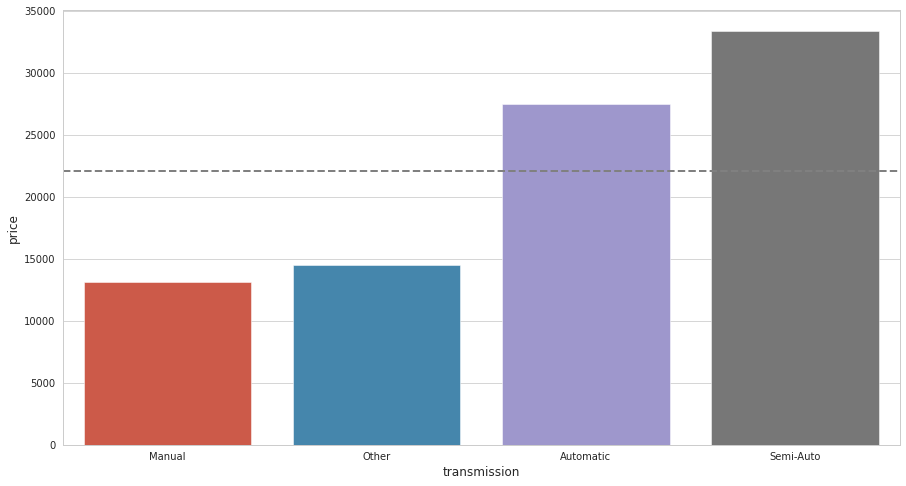

In [152]:
tran = df.groupby('transmission')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=tran.index,y='price',data=tran)
plt.axhline(y = tran['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

연료 유형별 평균단가

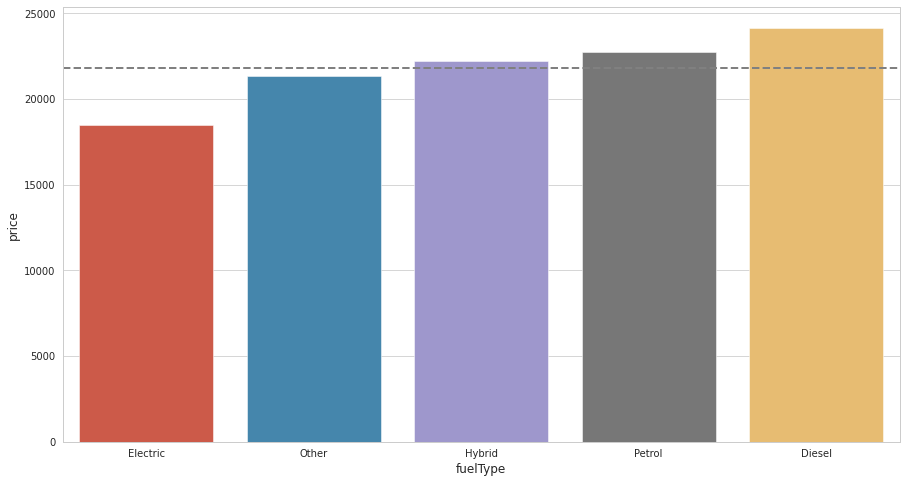

In [153]:
fuel = df.groupby('fuelType')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=fuel.index,y='price',data=fuel)
plt.axhline(y = fuel['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

수치형 컬럼에대한 상관관계분석 히트맵

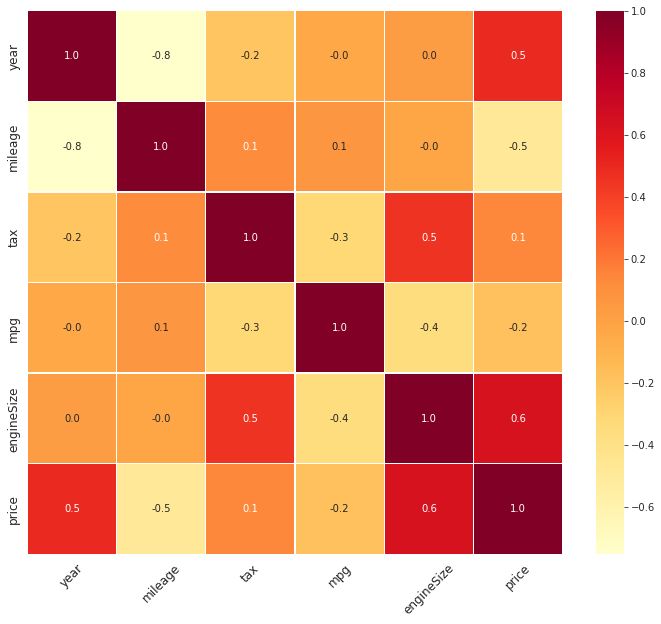

In [154]:
fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(df.corr(), # 위에서 전처리한 데이터프레임
            annot = True, # 숫자 표시 여부
            ax = ax, # 히트맵을 그릴 격자
            linewidths = 0.4, # 선의 굵기
            linecolor = 'white', # 선의 색깔
            fmt = '.1f', # 소수점 포맷팅 형태
            cmap = 'YlOrRd') # colormap 형태



plt.xticks(rotation=45, size = 12)
plt.yticks(size=12) 
plt.show()

## 4) 머신러닝 방식 적용 및 교차검증

In [466]:
target = df_1['price']
features = df_1.drop(columns='price')

In [465]:
df_1 = pd.get_dummies(df, columns=['brand','model','transmission', 'fuelType'])
df_1.head()

,year,mileage,tax,mpg,engineSize,price,brand_audi,brand_bmw,brand_ford,brand_hyundi,...,model_ i8,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2019,4223,145.0,39.8,2.2,31995,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
1,2015,47870,125.0,60.1,2.0,7700,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,2019,5151,145.0,29.1,2.9,58990,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,2016,20423,30.0,57.6,2.0,12999,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,2020,3569,145.0,47.1,1.0,16990,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [408]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['brand','model','transmission', 'fuelType']),
    remainder='passthrough')
transformer.fit(features)


ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['brand', 'model', 'transmission',
                                  'fuelType'])])

In [411]:
features = transformer.transform(features)

In [467]:
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=42)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(6105, 113) (1527, 113) (6105,) (1527,)


기준모델 생성

In [279]:
predict = df['price'].mean()

In [280]:
price=pd.DataFrame(df['price'])

In [281]:
price['predict'] = predict

In [282]:
price

,price,predict
0,31995,23579.922825
1,7700,23579.922825
2,58990,23579.922825
3,12999,23579.922825
4,16990,23579.922825
...,...,...
7627,28990,23579.922825
7628,17450,23579.922825
7629,21995,23579.922825
7630,18700,23579.922825


In [440]:
r2_score(price['price'], price['predict'])

0.0

릿지모형

In [468]:
from sklearn.model_selection import RandomizedSearchCV

pipe = make_pipeline(
    Ridge()
)



dists = { 
    'ridge__alpha': [0.1,1,10,100], 
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=100, 
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

clf.fit(x_train, y_train);
print('최적 하이퍼파라미터: ', clf.best_params_)
print('R2: ', clf.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
최적 하이퍼파라미터:  {'ridge__alpha': 0.1}
R2:  0.8718363385311901


라쏘

In [444]:
from sklearn.model_selection import RandomizedSearchCV

pipe = make_pipeline(
    Lasso()
)


dists = { 
    'lasso__alpha': [0.1,1,10,100], 
}

clf_1 = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=100, 
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

clf_1.fit(x_train, y_train);
print('최적 하이퍼파라미터: ', clf_1.best_params_)
print('R2: ', clf_1.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
최적 하이퍼파라미터:  {'lasso__alpha': 0.1}
R2:  0.8718454306401012


엘라스틱넷

In [446]:
from sklearn.model_selection import RandomizedSearchCV

pipe = make_pipeline(
    ElasticNet()
)


dists = { 
    'elasticnet__alpha': [0.1,1,10,100], 
}

clf_2 = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=100, 
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

clf_2.fit(x_train, y_train);
print('최적 하이퍼파라미터: ', clf_2.best_params_)
print('R2: ', clf_2.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
최적 하이퍼파라미터:  {'elasticnet__alpha': 0.1}
R2:  0.7413475769944787


In [492]:
dists = {
    'n_estimators': randint(50, 1000),
    'max_depth': randint(1,50), 
    'min_samples_leaf' : randint(1, 50),
    'max_features': ['sqrt','log2',None]}

clf_3 = RandomizedSearchCV(
    RandomForestRegressor(random_state=2), 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)

clf_3.fit(x_train, y_train)
print('최적 하이퍼파라미터: ', clf_3.best_params_)
print('R2: ', clf_3.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
최적 하이퍼파라미터:  {'max_depth': 22, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 751}
R2:  0.9459893445423989


In [448]:
pipe = make_pipeline(
    DecisionTreeRegressor(random_state=2)
)

dists = {
    'decisiontreeregressor__max_depth': randint(1,50), 
    'decisiontreeregressor__min_samples_leaf' : randint(1, 50),
    'decisiontreeregressor__max_features': ['sqrt','log2',None]
}

clf_4 = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)

clf_4.fit(x_train, y_train)
print('최적 하이퍼파라미터: ', clf_4.best_params_)
print('R2: ', clf_4.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
최적 하이퍼파라미터:  {'decisiontreeregressor__max_depth': 30, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__min_samples_leaf': 6}
R2:  0.9079050322763572


In [463]:
features

array([[  1. ,   0. ,   0. , ..., 145. ,  39.8,   2.2],
       [  0. ,   1. ,   0. , ..., 125. ,  60.1,   2. ],
       [  0. ,   0. ,   1. , ..., 145. ,  29.1,   2.9],
       ...,
       [  0. ,   0. ,   0. , ..., 145. ,  50.4,   1. ],
       [  0. ,   0. ,   0. , ..., 200. ,  41.5,   2. ],
       [  0. ,   1. ,   0. , ..., 565. ,  32.8,   2. ]])

In [469]:
print('릿지의 R2 Score :', clf.best_estimator_.score(x_test, y_test))

릿지의 R2 Score : 0.8815543113153083


In [494]:
print('릿지의 R2 Score :', clf.best_estimator_.score(x_test, y_test))
print('라쏘의 R2 Score :', clf_1.best_estimator_.score(x_test, y_test))
print('엘라스틱넷의 R2 Score :', clf_2.best_estimator_.score(x_test, y_test))
print('랜덤포레스트의 R2 Score :', clf_3.best_estimator_.score(x_test, y_test))
print('의사결정나무의 R2 Score :', clf_4.best_estimator_.score(x_test, y_test))

model = clf_3.best_estimator_

릿지의 R2 Score : 0.8815543113153083
라쏘의 R2 Score : -216288578.16842812
엘라스틱넷의 R2 Score : -16076372.516540425
랜덤포레스트의 R2 Score : 0.949048493926886
의사결정나무의 R2 Score : -0.8874441278925886


##  머신러닝 모델 해석

In [488]:
model = clf_3.best_estimator_

In [457]:
x_train

array([[  0. ,   0. ,   0. , ..., 160. ,  48.7,   2. ],
       [  0. ,   0. ,   0. , ..., 260. ,  33.2,   2. ],
       [  0. ,   0. ,   0. , ..., 160. ,  48.7,   2. ],
       ...,
       [  0. ,   0. ,   0. , ..., 145. ,  44.1,   1.5],
       [  0. ,   0. ,   0. , ..., 145. ,  34.9,   3. ],
       [  0. ,   0. ,   0. , ..., 325. ,  28.8,   2.3]])

In [458]:
x_test

array([[  0. ,   0. ,   1. , ..., 145. ,  33.6,   3. ],
       [  0. ,   0. ,   0. , ..., 145. ,  41.5,   1.6],
       [  0. ,   0. ,   0. , ..., 570. ,  25.2,   3. ],
       ...,
       [  1. ,   0. ,   0. , ...,  30. ,  65.7,   1.7],
       [  0. ,   0. ,   0. , ...,  30. ,  58.9,   1.5],
       [  1. ,   0. ,   0. , ..., 145. ,  53.3,   1.7]])

In [497]:
row = x_test.iloc[[1]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row

,year,mileage,tax,mpg,engineSize,brand_audi,brand_bmw,brand_ford,brand_hyundi,brand_merc,...,model_ i8,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
1964,2018,21981,145.0,41.5,1.6,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [328]:
data=(pd.DataFrame(x_test.iloc[300]))

In [331]:
data = orderinal.fit(data)

In [482]:
import eli5

from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring = 'r2',
    n_iter = 10,
    random_state = 2
)

permuter.fit(x_test, y_test)

pi = pd.DataFrame({'feature' : x_test.columns,
                   'importance' : permuter.feature_importances_}).sort_values('importance', ascending = True)

pi

,feature,importance
104,transmission_Automatic,-0.000162
37,model_ Eos,-0.000129
81,model_ SQ5,-0.000094
21,model_ Antara,-0.000089
82,model_ SQ7,-0.000054
...,...,...
3,mpg,0.069126
5,brand_audi,0.081005
4,engineSize,0.109159
6,brand_bmw,0.116803


In [460]:
x_test_encoded.iloc[:300]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
683,1,1,2019,1,10521,1,145.0,33.6,3.0
1964,2,2,2018,2,21981,2,145.0,41.5,1.6
6021,3,3,2012,1,43000,1,570.0,25.2,3.0
3378,2,4,2017,1,22141,2,145.0,46.3,1.8
4738,4,5,2008,2,63000,2,160.0,45.6,1.3
...,...,...,...,...,...,...,...,...,...
4640,3,36,2014,3,35000,1,150.0,56.5,2.0
4368,1,56,2017,3,17889,2,145.0,34.0,2.5
6299,5,51,2018,1,14827,2,145.0,42.8,2.0
6193,8,42,2016,2,48687,1,30.0,65.7,1.7


(<Figure size 1050x665 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f40a7eb8d90>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f40a7dbeb90>})

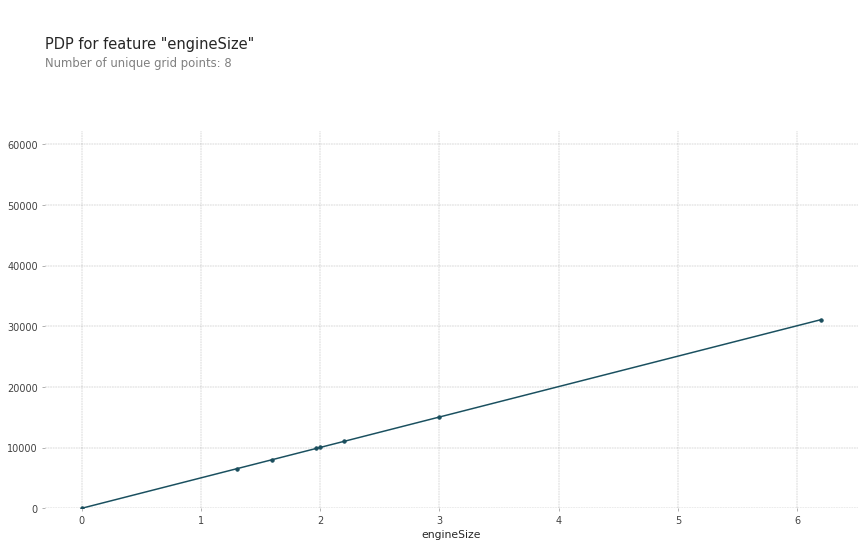

In [480]:
from pdpbox.pdp import pdp_isolate, pdp_plot

# Ram
isolate_ram = pdp_isolate(
    model = model,
    dataset = x_test,
    model_features = x_test.columns,
    feature = 'engineSize',
    grid_type = 'percentile',
    num_grid_points = 10
)

pdp_plot(isolate_ram, feature_name = 'engineSize')

In [266]:
data = x_test_encoded
shap.initjs()
svc_explainer = shap.KernelExplainer(model.predict,x_train_encoded)
svc_shap_values = svc_explainer.shap_values(x_test_encoded, nsamples=100)
sp.summary_plot(svc_shap_values, x_test_encoded)

  0%|          | 0/1527 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## 모델 예측

In [477]:
x_test[:1]

,year,mileage,tax,mpg,engineSize,brand_audi,brand_bmw,brand_ford,brand_hyundi,brand_merc,...,model_ i8,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
683,2019,10521,145.0,33.6,3.0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [476]:
test = [['hyundi','I40',2015,'Manual',33036,'Diesel',20.0,67.3,1.7]]
test=(pd.DataFrame(test,columns=['brand',	'model','year','transmission','mileage','fuelType','tax',	'mpg','engineSize']))
test = pd.get_dummies(test, columns=['brand','model','transmission', 'fuelType'])
test.head()
#test = transformer.transform(test)
model.predict(x_test[:1])

array([58510.19871987])